# Hands-on Cython and Numba

Python is a popular programming language in natural hazards engineering research because it is free and open-source, and has a plethora of powerful packages for handling our community’s computing needs. However, Python is an interpreted language and is inherently slower and less efficient than compiled languages like Fortran, C, and C++. As a result, many scripts written in Python, particularly those involving loops, can run significantly faster with a few minor modifications. This webinar will demonstrate how vectorized calculations using Numpy arrays and Scipy are significantly faster than the same operations coded in Python. We will demonstrate how to use Cython to compile Python code to C, which can improve performance by orders of magnitude. We will also demonstrate how to use just in time (JIT) compilation to accelerate Python, particularly using GPU’s.

## Heat Flow Problem

The relative performance of different coding approaches is demonstrated using a finite difference solution to the 2D transient heat flow problem for a square domain with a constant initial temperature subject to a temperature change on the top.

## Governing differential equation

$\frac{\partial T}{\partial t} = \alpha \left[ \frac{\partial ^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}\right]$

T = temperature  
t = time  
x = horizontal dimension  
y = vertical dimension  
$\alpha$ = thermal diffusivity  

## Finite different approximation for a rectangular mesh
$\frac{\partial T}{\partial t} \approx \frac{T_{ij}^{k+1} - T_{ij}^{k}}{\Delta t}$  
$\frac{\partial ^2 T}{\partial x^2} \approx \alpha \frac{T_{i+1,j}^k -2T_{i,j}^k + T_{i-1,j}^k}{\Delta x^2}$  
$\frac{\partial ^2 T}{\partial y^2} \approx \alpha \frac{T_{1,j+1}^k -2T_{i,j}^k + T_{i,j-1}^k}{\Delta y^2}$  

$\Delta x$ = node spacing in x-direction  
$\Delta y$ = node spacing in y-direction
$\Delta t$ = time step
i = index counter for x-direction  
j = index counter for y-direction  
k = index counter for time  

### Resulting equation

$\frac{T_{ij}^{k+1} - T_{ij}^{k}}{\Delta t} = \alpha \frac{T_{i+1,j}^k -2T_{i,j}^k + T_{i-1,j}^k}{\Delta x^2} + \alpha \frac{T_{1,j+1}^k -2T_{i,j}^k + T_{i,j-1}^k}{\Delta y^2}$  

### If $\Delta x = \Delta y$ we obtain the following

$\frac{T_{ij}^{k+1} - T_{ij}^{k}}{\Delta t} = \alpha \frac{T_{i+1,j}^k + T_{1,j+1}^k -4T_{i,j}^k + T_{i-1,j}^k + T_{i,j-1}^k}{\Delta x^2}$  

### Solving for $T_{ij}^{k+1}$ and re-arranging terms

$T_{ij}^{k+1} = \gamma\left(T_{i+1,j}^k + T_{1,j+1}^k + T_{i-1,j}^k + T_{i,j-1}^k\right) + \left(1 - 4\gamma\right)T_{ij}^k$  

where $\gamma = \frac{\alpha \Delta t}{\Delta x^2}$


### Note: the solution will become unstable if $\left(1 - \frac{4\alpha \Delta t}{\Delta x^2} \right) < 0$. We therefore set the time step as shown below.

$\Delta t = \frac{\Delta x^2}{4\alpha}$  

### Using the time step above, we find that $\left(1-4\gamma\right)=0$ and therefore the resulting equation is:

$T_{ij}^{k+1} = \gamma\left(T_{i+1,j}^k + T_{i,j+1}^k + T_{i-1,j}^k + T_{i,j-1}^k\right)$  


## Define input variables

`L`         = plate length  
`Nt`        = number of time steps  
`Nx`        = number of increments in x-direction (same as y-direction since plate is square)  
`alpha`     = thermal diffusivity  
`dx`        = node spacing  
`dt`        = time increment  
`T_top`     = temperature of top of plate  
`T_left`    = temperature of left side of plate  
`T_right`   = temperature of right side of plate  
`T_bottom`  = temperature of bottom of plate  
`T_initial` = initial temperature of plate  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

L = 50
Nt = 1000
Nx = 50
alpha = 2.0
dx = L/Nx
dt = dx**2/4.0/alpha
gamma = alpha*dt/dx/dx
T_top = 100.0
T_left = 0.0
T_right = 0.0
T_bottom = 0.0
T_initial = 0.0

# Initialize Numpy array T to store temperature values
T = np.full((Nt,Nx,Nx),T_initial,dtype=float)
T[:,:,:1] = T_left
T[:,:,Nx-1] = T_right
T[:,:1,:] = T_bottom
T[:,Nx-1:, :] = T_top


In [2]:
def calculate_python(T,gamma):
    Nt = len(T)
    Nx = len(T[0])
    for k in range(0,Nt-1,1):
        for i in range(1,Nx-1,1):
            for j in range(1,Nx-1,1):
                T[k+1,i,j] = gamma*(T[k,i+1,j] + T[k,i-1,j] + T[k,i,j+1] + T[k,i,j-1])
    return T

In [3]:
%load_ext cython

In [4]:
%%cython
import cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False) 
def calculate_cython(double[:,:,:] T, double gamma):
    cdef int i, j, k
    cdef int K = len(T)-1
    cdef int I = len(T[0])-1
    for k in range(0,K,1):
        for i in range(1,I,1):
            for j in range(1,I,1):
                T[k+1][i][j] = gamma*(T[k][i+1][j] + T[k][i-1][j] + T[k][i][j+1] + T[k][i][j-1])
    return np.asarray(T)

## Using Numba JIT

In [5]:
import numba
import numpy as np
from numba.typed import List

@numba.jit(nopython=True)
def calculate_numba(T, gamma):
    Nt = len(T)
    Nx = len(T[0])
    for k in range(0, Nt - 1, 1):
        for i in range(1, Nx - 1, 1):
            for j in range(1, Nx - 1, 1):
                T[k + 1, i, j] = gamma * (T[k, i + 1, j] + T[k, i - 1, j] + T[k, i, j + 1] + T[k, i, j - 1])
    return T

def calculate_numba_wrapper(T, gamma):
    T_list = List()
    T_list.append(np.asarray(T))
    T_numba = calculate_numba(T_list[0], gamma)
    return T_numba

## Writing convolution rather than a loop

In [6]:
import numpy as np
from scipy.signal import convolve

def calculate_conv(T, gamma):
    Nt = len(T)
    Nx = len(T[0])
    # Define the kernel for convolution (Laplacian operator)
    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])

    # Ensure u is a NumPy array
    T = np.array(T)

    for k in range(0,Nt - 1, 1):
        # Convolve u[k] with the kernel, then multiply by gamma and add u[k]
        T[k + 1, 1:Nx - 1:1, 1:Nx - 1:1] = (
            gamma * convolve(T[k], kernel, mode='same')[1:Nx - 1:1, 1:Nx - 1:1] + T[k, 1:Nx - 1:1, 1:Nx - 1:1]
        )
    return T


## Performance measurement

In [7]:
import time
start_time = time.time()
T_python = calculate_python(T, gamma)
print(f"Pure Python time: = {time.time() - start_time:.3f} seconds")
start_time = time.time()
T_cython = calculate_cython(T, gamma)
print(f"Cython time: = {time.time() - start_time:.3f} seconds")
start_time = time.time()
T_numba = calculate_numba_wrapper(T, gamma)
print(f"Numba time: = {time.time() - start_time:.3f} seconds")
start_time = time.time()
T_convolve = calculate_conv(T, gamma)
print(f"Python Convolution time: = {time.time() - start_time:.3f} seconds")

Pure Python time: = 2.892 seconds
Cython time: = 0.000 seconds
Numba time: = 1.205 seconds
Python Convolution time: = 0.322 seconds


## Plot heat maps to make sure the algorithms are the same

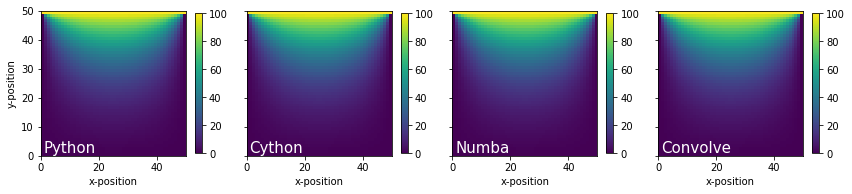

In [16]:
fig, ax = plt.subplots(ncols=4,figsize=(12,3),sharey='row')
k = 999
data = {'Python':T_python[k], 'Cython':T_cython[k], 'Numba':T_numba[k], 'Convolve':T_convolve[k]}
i = 0
for key, value in data.items():
    pcm = ax[i].pcolormesh(value, cmap=plt.cm.viridis, vmin=0, vmax=100)
    ax[i].set_xlabel('x-position')
    ax[i].set_aspect('equal')
    ax[i].annotate(key, xy=(1,1), c='white', fontsize=15)
    fig.colorbar(pcm,ax=ax[i],shrink=0.75)
    i+=1    
ax[0].set_ylabel('y-position')
#fig.colorbar(pcm)
plt.tight_layout()

## Large-scale problem

Wow! Cython and Numba are so much faster than pure Python. It's difficult to observe differences in performance for such a small domain, so let's increase the mesh density so the calculations take a little bit longer

In [17]:
L = 50
Nt = 4000
Nx = 200
alpha = 2.0
dx = L/Nx
dt = dx**2/4.0/alpha
T_top = 100.0
T_left = 0.0
T_right = 0.0
T_bottom = 0.0
T_initial = 0.0
T = np.empty((Nt,Nx,Nx))
T.fill(T_initial)
T[:,:,:1] = T_left
T[:,:,Nx-1] = T_right
T[:,:1,:] = T_bottom
T[:,Nx-1:, :] = T_top
start_time = time.time()
T_cython = calculate_cython(T, gamma)
print(f"Cython time: = {time.time() - start_time:.3f} seconds")
start_time = time.time()
T_numba = calculate_numba_wrapper(T, gamma)
print(f"Numba time: = {time.time() - start_time:.3f} seconds")

Cython time: = 0.282 seconds
Numba time: = 0.564 seconds
